This notebook describes how to implement SIRT using tomosipo. 

Given the tomographic inverse problem
$$ A x = y, $$
The SIRT algorithm updates it's estimate $x$ iteratively as follows:
$$    x_{i+1} = x_i + C  A^T R  (y - A x_i). $$

Here, $R$ and $C$ are diagonal matrices containing the row and column sums of $A$, respectively. 

For more information, see https://tomroelandts.com/articles/the-sirt-algorithm

In [46]:
import tomosipo as ts
import cupy as cp
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

def plot_imgs(height=3, cmap="gray", clim=(-.5, 1.5), **kwargs):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(kwargs),
        figsize=(height * len(kwargs), height)
    )
    if len(kwargs) == 1:
        axes = [axes]
    for ax, (k, v) in zip(axes, kwargs.items()):
        pcm = ax.imshow(v.get().squeeze(), cmap=cmap, clim=clim)
        fig.colorbar(pcm, ax=ax)
        ax.set_title(k)
    fig.tight_layout()



Compiling kernel RayDrivenConeFP with arguments {'slices_per_thread': 64, 'pixels_per_thread': 32, 'nr_projs_global': 1024, 'volume_axes': (0, 1, 2), 'projection_axes': (0, 1, 2)}...
Compiling kernel VoxelDrivenConeBP with arguments {'nr_vxls_block_x': 16, 'nr_vxls_block_y': 32, 'nr_vxls_block_z': 6, 'nr_projs_block': 32, 'nr_projs_global': 1024, 'texture': 'tex2DLayered', 'volume_axes': (0, 1, 2), 'projection_axes': (0, 1, 2)}...


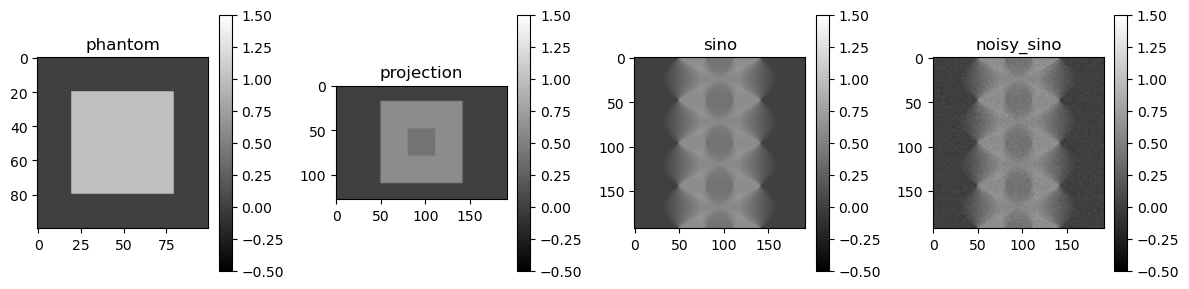

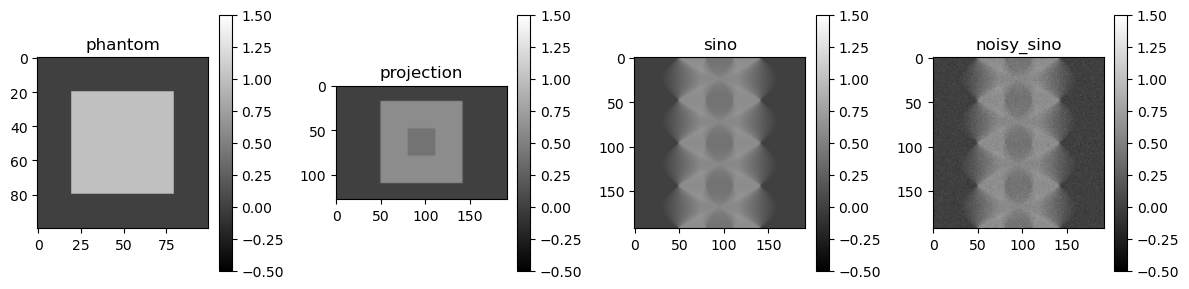

In [47]:
# Volume is the unit cube with N^3 voxels. 
# projection geometry is 1.5 units wide and 1 unit high.
N = 128
full_vg = ts.volume(size=(1.0, 1.0, 1.0), shape=(100, 100, 100))
SOD = 200
SDD = 1.2 * SOD
full_pg = ts.cone(angles=3 * N // 2, shape=(N, 3 * N // 2), size=(1, 1.5),
                  src_orig_dist=SOD, src_det_dist=SDD)

# ---

A = ts.operator(full_vg, full_pg, backend='kernelkit')
phantom = cp.asarray(ts.phantom.hollow_box(ts.data(full_vg)).data)
sino = A(phantom)
noisy_sino = cp.asarray(sino + sino.max() / 20 * cp.random.randn(*sino.shape),
                        dtype=cp.float32)
plot_imgs(
    phantom=phantom[:, :, 64],       # central axial slice
    projection=sino[0, :, :],  # first projection image
    sino=sino[:, 64, :],  # sinogram of central slice
    noisy_sino=noisy_sino[:, 64, :]  # noisy sinogram
)

# ---
A = ts.operator(full_vg, full_pg)
phantom = cp.asarray(ts.phantom.hollow_box(ts.data(full_vg)).data)
sino = A(phantom)
noisy_sino = cp.asarray(sino + sino.max() / 20 * cp.random.randn(*sino.shape),
                        dtype=cp.float32)
plot_imgs(
    phantom=phantom[64],       # central axial slice
    projection=sino[:, 0, :],  # first projection image
    sino=sino[64, ...],        # sinogram of central slice
    noisy_sino=noisy_sino[64, ...], # noisy sinogram
)    

Compiling kernel RayDrivenConeFP with arguments {'slices_per_thread': 64, 'pixels_per_thread': 32, 'nr_projs_global': 1024, 'volume_axes': (0, 1, 2), 'projection_axes': (0, 1, 2)}...
Compiling kernel VoxelDrivenConeBP with arguments {'nr_vxls_block_x': 16, 'nr_vxls_block_y': 32, 'nr_vxls_block_z': 6, 'nr_projs_block': 32, 'nr_projs_global': 1024, 'texture': 'tex2DLayered', 'volume_axes': (0, 1, 2), 'projection_axes': (0, 1, 2)}...
KernelkitOperator:


100%|██████████| 100/100 [00:03<00:00, 25.42it/s]


Operator:


100%|██████████| 100/100 [00:04<00:00, 23.68it/s]


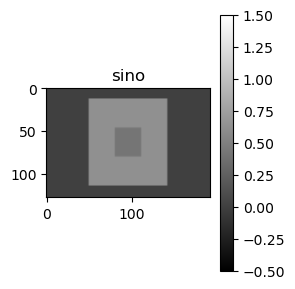

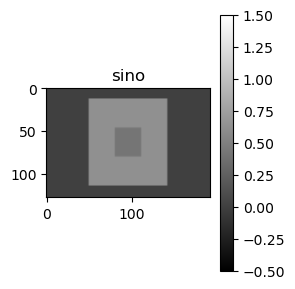

In [48]:
# Volume is the unit cube with N^3 voxels. 
# projection geometry is 1.5 units wide and 1 unit high.
N = 128
full_vg = ts.volume(size=(1.1, 1.05, 1.0), shape=(110, 105, 100))
SOD = 200
SDD = 1.2 * SOD
full_pg = ts.cone(angles=3 * N // 2, shape=(N, 3 * N // 2), size=(1, 1.5),
                  src_orig_dist=SOD, src_det_dist=SDD)

phantom = cp.asarray(ts.phantom.hollow_box(ts.data(full_vg)).data)

A_kk = ts.operator(full_vg, full_pg, backend='kernelkit')
A_tb = ts.operator(full_vg, full_pg)
for A in (A_kk, A_tb):
    print(f"{A.__class__.__name__}:")
    sino = A(phantom)
    noisy_sino = cp.asarray(sino + sino.max() / 20 * cp.random.randn(*sino.shape),
                            dtype=cp.float32)
    # for _ in tqdm(range(100)):
    #     x = A.T(noisy_sino)
        
    for _ in tqdm(range(100)):
        sino = A._fp(phantom)

    if isinstance(A, ts.Operator.KernelkitOperator):
        plot_imgs(
            # x=phantom[..., 54],       # central axial slice
            sino=sino[0]
        )    
    else:
        plot_imgs(
            # x=phantom[..., 54],       # central axial slice
            sino=sino[:, 0]
        )    

100%|██████████| 100/100 [00:04<00:00, 23.08it/s]


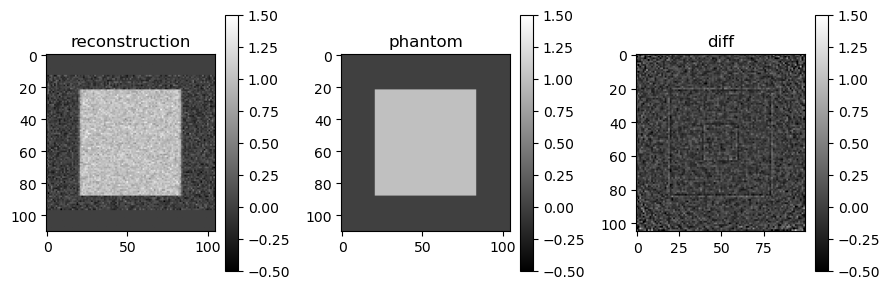

In [49]:
# Naive SIRT implementation.

# We can either create tensors directly on the GPU, or create 
# tensors on the CPU --- using `torch.device("cpu")` --- and 
# let ASTRA move the data back and forth. This results in a kind
# of "ping pong" effect, where the data is moved to and from GPU 
# just for ASTRA. Therefore, if you change the device to "cpu", 
# you will find that performance is roughly halved. 

A = A_kk
sino = A(phantom)
y = cp.asarray(sino + sino.max() / 20 * cp.random.randn(*sino.shape),
                        dtype=cp.float32)
x_cur = cp.zeros(A.domain_shape, dtype=cp.float32)

C = 1.0 / A.T(cp.ones_like(y))
C[C == cp.infty] = 0.0
R = 1.0 / A(cp.ones_like(x_cur))
R[R == cp.infty] = 0.0

# Just like the formula :) 
num_iters = 100
for i in tqdm(range(num_iters)):
    x_cur += C * A.T(R * (y - A(x_cur)))

if isinstance(A, ts.Operator.KernelkitOperator):
    plot_imgs(
        reconstruction=x_cur[..., 64], 
        phantom=phantom[..., 64],
        diff = (x_cur - phantom)[64],
    )    
else:
    plot_imgs(
        reconstruction=x_cur[64], 
        phantom=phantom[64],
        diff = (x_cur - phantom)[64],
    )    

100%|██████████| 100/100 [00:04<00:00, 21.98it/s]


<Figure size 640x480 with 0 Axes>

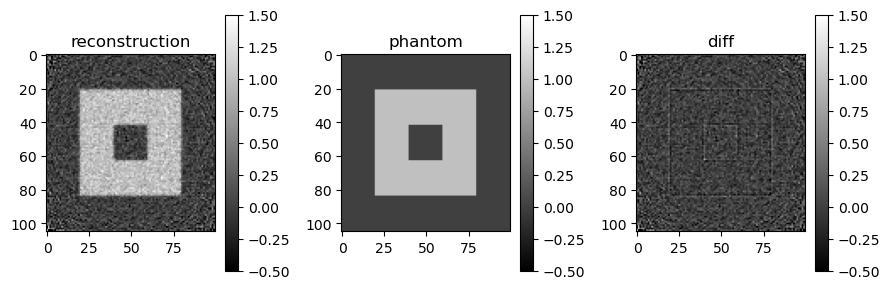

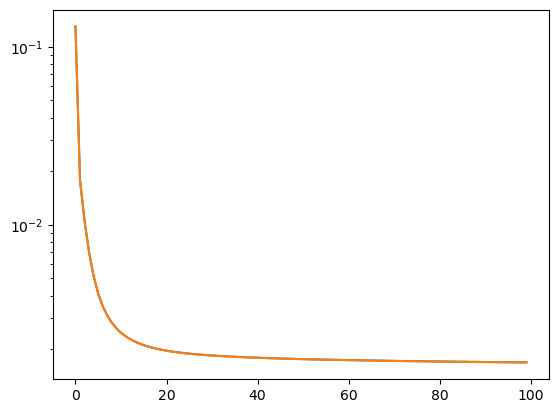

<Figure size 640x480 with 0 Axes>

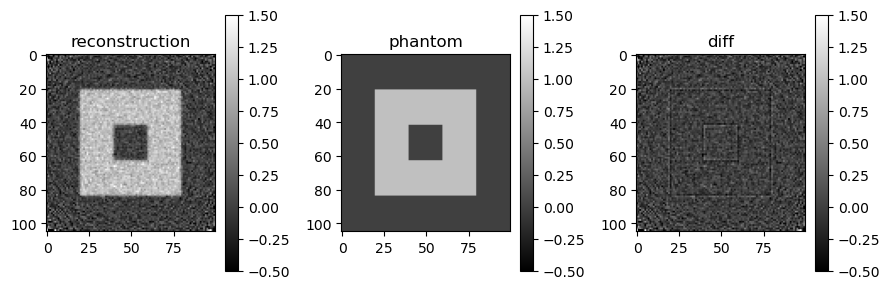

In [50]:
# Here, we implement a slightly more optimized version. 
# This is not much faster, but it avoids allocating some intermediate tensors, 
# which is nice when you are close to the memory limit. 
for A in (A_tb, A_kk):
    sino = A(phantom)
    y = cp.asarray(sino + sino.max() / 20 * cp.random.randn(*sino.shape),
                            dtype=cp.float32)
    x_cur = cp.zeros(A.domain_shape, dtype=cp.float32)

    y_tmp = cp.ones_like(y)
    C = 1.0 / A.T(y_tmp)
    C[C == cp.infty] = 0.0

    x_tmp = cp.ones_like(x_cur)
    R = 1.0 / A(x_tmp)
    R[R == cp.infty] = 0.0

    num_iters = 100
    residuals = np.zeros(num_iters)
    for i in tqdm(range(num_iters)):
        A(x_cur, out=y_tmp)
        y_tmp -= y    # flip sign here
        
        # We can keep track of the residual error in the projection data
        residuals[i] = cp.square(y_tmp).mean()
        
        y_tmp *= R
        A.T(y_tmp, out=x_tmp)
        x_tmp *= C
        x_cur -= x_tmp # flip sign here
        
    plt.figure(1)
    plt.plot(residuals)
    plt.yscale('log')

    if isinstance(A, ts.Operator.KernelkitOperator):
        plt.figure()
        plot_imgs(
            reconstruction=x_cur[64], 
            phantom=phantom[64],
            diff=(x_cur - phantom)[64],
        )    
    else:
        plt.figure()
        plot_imgs(
            reconstruction=x_cur[64], 
            phantom=phantom[64],
            diff=(x_cur - phantom)[64],
        )    